<a href="https://colab.research.google.com/github/j223104/MLproject1/blob/main/Ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

train test  나누기

In [6]:
import os
# !unzip /content/drive/MyDrive/ColabNotebooks/btc_20.zip

!pip install split-folders

  Using cached split_folders-0.4.3-py3-none-any.whl (7.4 kB)


In [15]:
from shutil import copyfile, move
path = "{}/{}".format(os.getcwd(), "")
import splitfolders
# os.makedirs("/train")

# for filename in os.listdir(path):
#         if filename != '' and filename != 'drive' and filename !="sample_data":
#                   move("{}/{}".format(path, filename),"{}/dataset".format(path))

os.makedirs("/test_train_val")          
import splitfolders
splitfolders.ratio('dataset', output="test_train_val", seed=42, ratio=(.8, 0.1,0.1)) 

Copying files: 1 files [00:00,  8.38 files/s]


In [25]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)
src = 'dataset'
# new_dir = 'test_train_val'
# os.makedirs(new_dir +'/train')
# os.makedirs(new_dir +'/test')
# os.makedirs(new_dir +'/val')
# Creating partitions of the data after shuffeling

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


train_FileNames1 = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames1 = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames1 = [src+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames1))
print('Validation: ', len(val_FileNames1))
print('Testing: ', len(test_FileNames1))

# Copy-pasting images
for name in train_FileNames:
    move(f"dataset/{name}",
                     "test_train_val/train/{}".format(name))

for name in val_FileNames:
        move(f"dataset/{name}",
                     "test_train_val/val/{}".format(name))

for name in test_FileNames:
        move(f"dataset/{name}","test_train_val/test/{}".format(name))

Total images:  21009
Training:  14706
Validation:  3151
Testing:  3152


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [58]:
# a = "vbtc-ddd_2.png".split("_")[1][2:]
# a
folder = ["test","train","val"]
for fd in folder:
  for i in range(1,4):
    src = f"test_train_val/{fd.rstrip()}"
    if not os.path.exists(f"/content/test_train_val/{fd.rstrip()}/{i}"):
        os.makedirs(f"/content/test_train_val/{fd.rstrip()}/{i}")
    for filename in os.listdir(src):
       if len(filename) >= 5 and filename.split("_")[1][:1] == f"{i}" and filename.split("_")[1][2:] == 'png':
          move(f"test_train_val/{fd.rstrip()}/{filename.rstrip()}", f"test_train_val/{fd.rstrip()}/{i}/{filename.rstrip()}")
       else : ""

In [4]:
!rm rm -rf `find -type d -name .ipynb_checkpoints`
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory(
  "test_train_val/train",
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=42,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  "test_train_val/test",
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=42,
  class_mode='categorical',
  shuffle=False
)


Found 15422 images belonging to 3 classes.
Found 3151 images belonging to 3 classes.


In [71]:
from pprint import pprint
pprint(train_gen.class_indices)

{'1': 0, '2': 1, '3': 2}


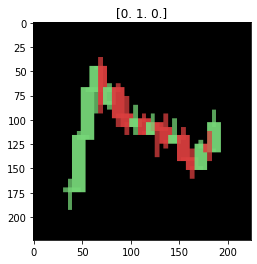

In [72]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[8])

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

input = Input(shape=(224, 224, 3))

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1.0e-4), metrics=['acc'])

model.summary()

In [75]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data= test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20, # epochs 복수형으로 쓰기!
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
482/482 [==============================] - ETA: 0s - loss: 0.8764 - acc: 0.4986
Epoch 00001: val_acc improved from -inf to 0.50460, saving model to model.h5
482/482 [==============================] - 141s 275ms/step - loss: 0.8764 - acc: 0.4986 - val_loss: 0.7892 - val_acc: 0.5046
Epoch 2/20
482/482 [==============================] - ETA: 0s - loss: 0.7924 - acc: 0.5294
Epoch 00002: val_acc improved from 0.50460 to 0.53221, saving model to model.h5
482/482 [==============================] - 128s 266ms/step - loss: 0.7924 - acc: 0.5294 - val_loss: 0.7782 - val_acc: 0.5322
Epoch 3/20
482/482 [==============================] - ETA: 0s - loss: 0.7699 - acc: 0.5613
Epoch 00003: val_acc improved from 0.53221 to 0.54395, saving model to model.h5
482/482 [==============================] - 128s 266ms/step - loss: 0.7699 - acc: 0.5613 - val_loss: 0.7794 - val_acc: 0.5440
Epoch 4/20
482/482 [==============================] - ETA: 0s - loss: 0.7186 - acc: 0.6204
Epoch 00004: val_acc imp

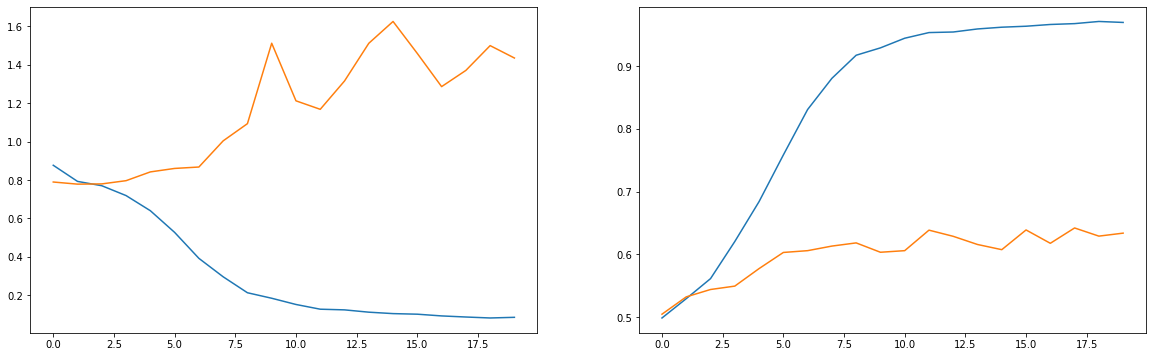

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

In [6]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


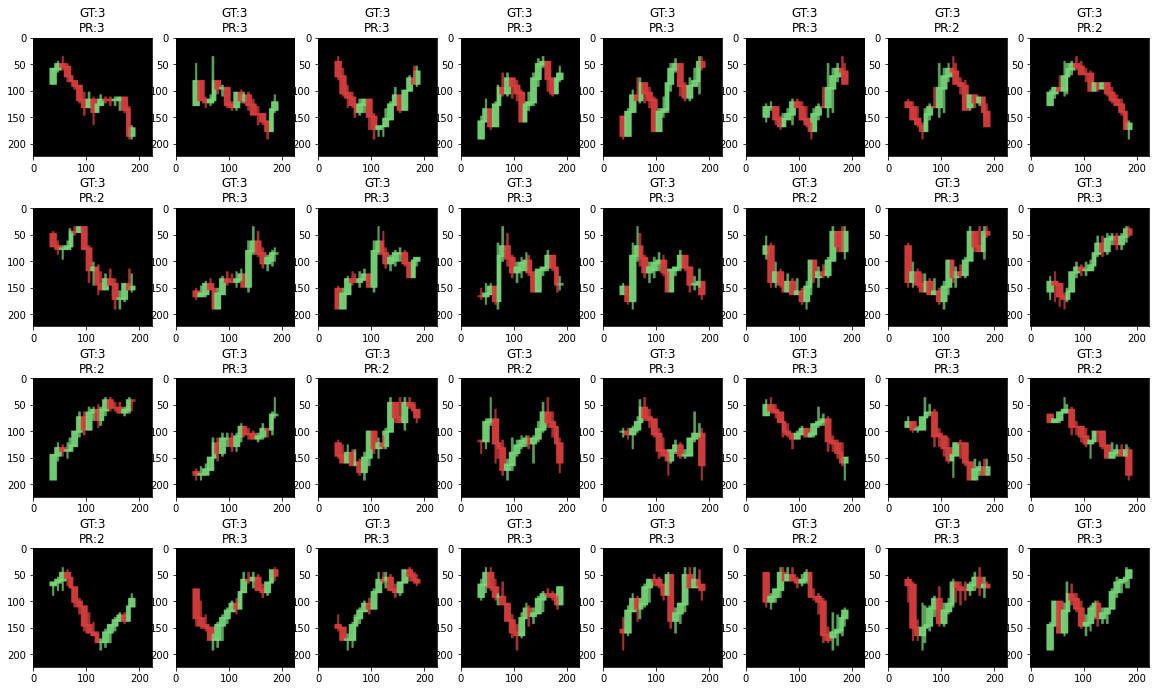

In [83]:
test_imgs, test_labels = val_gen.__getitem__(60)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)

In [36]:
val_gen = test_datagen.flow_from_directory(
  "test_train_val/val",
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=42,
  class_mode='categorical',
  shuffle=False
) 



Found 3150 images belonging to 3 classes.
-- Evaluate --


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


['loss', 'acc']: 46.25%


In [50]:
print("-- Evaluate --")
scores = model.evaluate_generator(val_gen)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" %(model.metrics_names[0], scores[0]))

-- Evaluate --


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


acc: 63.33%
loss: 1.39%


0